In [0]:
!pip install http://download.pytorch.org/whl/cu90/torch-1.0.0-cp36-cp36m-linux_x86_64.whl
!pip install torchvision
!pip install tqdm


In [0]:
import torch
from torch import nn, optim
from torch.utils.data import (Dataset, DataLoader, TensorDataset)
import tqdm

from torchvision.datasets import FashionMNIST
from torchvision import transforms

# 훈련용 데이터 가져오기
# 초기 상태에선 PIL（Python Imaging Library) 이미지 형식으로
# Dataset를 만들어 버린다.
# 따라서 transforms.ToTensor를 사용해 Tensor로 변환한다
fashion_mnist_train = FashionMNIST("/content/FashionMNIST",
    train=True, download=True,
    transform=transforms.ToTensor())
# 검증용 데이터 가져오기
fashion_mnist_test = FashionMNIST("/content/FashionMNIST",
    train=False, download=True,
    transform=transforms.ToTensor())

# 배치 크기가 128인 DataLoader를 각각 작성
batch_size=128
train_loader = DataLoader(fashion_mnist_train,
                          batch_size=batch_size, shuffle=True)
test_loader = DataLoader(fashion_mnist_test,
                          batch_size=batch_size, shuffle=False)

In [0]:
# (N, C, H, W)혀익의 Tensor를(N, C*H*W)로 늘리는 계층
# 합성곱 출력을 MLP에 전달할 때 필요
class FlattenLayer(nn.Module):
    def forward(self, x):
        sizes = x.size()
        return x.view(sizes[0], -1)

# 5×5의 커널을 사용해서 처음에 32개, 다음에 64개의 채널 작성
# BatchNorm2d는 이미지용 Batch Normalization
# Dropout2d는 이미지용 Dropout
# 마지막으로 FlattenLayer 적용
conv_net = nn.Sequential(
    nn.Conv2d(1, 32, 5),
    nn.MaxPool2d(2),
    nn.ReLU(),
    nn.BatchNorm2d(32),
    nn.Dropout2d(0.25),
    nn.Conv2d(32, 64, 5),
    nn.MaxPool2d(2),
    nn.ReLU(),
    nn.BatchNorm2d(64),
    nn.Dropout2d(0.25),
    FlattenLayer()
)

# 합성곱에 의해 최종적으로 이미지 크기가 어떤지를
# 더미 데이터를 넣어서 확인한다

test_input = torch.ones(1, 1, 28, 28)
conv_output_size = conv_net(test_input).size()[-1]

# 2층 MLP
mlp = nn.Sequential(
    nn.Linear(conv_output_size, 200),
    nn.ReLU(),
    nn.BatchNorm1d(200),
    nn.Dropout(0.25),
    nn.Linear(200, 10)
)
# 최종 CNN
net = nn.Sequential(
    conv_net,
    mlp
)

In [0]:
# 평가용 헬퍼 함수
def eval_net(net, data_loader, device="cpu"):
    # Dropout 및 BatchNorm을 무효화
    net.eval()
    ys = []
    ypreds = []
    for x, y in data_loader:
        # to 메서드로 계산을 실행할 디바이스로 전송
        x = x.to(device)
        y = y.to(device)
        # 확률이 가장 큰 클래스를 예측(리스트 2.1 참조)
        # 여기선 forward（추론） 계산이 전부이므로 자동 미분에
        # 필요한 처리는 off로 설정해서 불필요한 계산을 제한다
        with torch.no_grad():
            _, y_pred = net(x).max(1)
        ys.append(y)
        ypreds.append(y_pred)
    
    # 미니 배치 단위의 예측 결과 등을 하나로 묶는다
    ys = torch.cat(ys)
    ypreds = torch.cat(ypreds)
    # 예측 정확도 계산
    acc = (ys == ypreds).float().sum() / len(ys)
    return acc.item()

# 훈련용 헬퍼 함수
def train_net(net, train_loader, test_loader,
              optimizer_cls=optim.Adam,
              loss_fn=nn.CrossEntropyLoss(),
              n_iter=10, device="cpu"):
    train_losses = []
    train_acc = []
    val_acc = []
    optimizer = optimizer_cls(net.parameters())
    for epoch in range(n_iter):
        running_loss = 0.0
        # 신경망을 훈련 모드로 설정
        net.train()
        n = 0
        n_acc = 0
        # 시간이 많이 걸리므로 tqdm을 사용해서 진행바를 표시
        for i, (xx, yy) in tqdm.tqdm(enumerate(train_loader),
            total=len(train_loader)):
            xx = xx.to(device)
            yy = yy.to(device)
            h = net(xx)
            loss = loss_fn(h, yy)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            n += len(xx)
            _, y_pred = h.max(1)
            n_acc += (yy == y_pred).float().sum().item()
        train_losses.append(running_loss / i)
        # 훈련 데이터의 예측 정확도
        train_acc.append(n_acc / n)

        # 검증 데이터의 예측 정확도
        val_acc.append(eval_net(net, test_loader, device))
        # epoch의 결과 표시
        print(epoch, train_losses[-1], train_acc[-1],
            val_acc[-1], flush=True)

In [0]:
# 신경망의 모든 파라미터를 GPU로 전송
net.to("cuda:0")

# 훈련 실행
train_net(net, train_loader, test_loader, n_iter=20, 
device="cuda:0")

In [0]:
!wget https://github.com/lucidfrontier45/PyTorch-Book/raw/master/data/taco_and_burrito.tar.gz
!tar -zxvf taco_and_burrito.tar.gz

In [0]:
from torchvision.datasets import ImageFolder
from torchvision import transforms

# ImageFolder 함수를 사용해서 Dataset 작성
train_imgs = ImageFolder("/content/taco_and_burrito/train/",
    transform=transforms.Compose([
        transforms.RandomCrop(224),
        transforms.ToTensor()]
))
test_imgs = ImageFolder("/content/taco_and_burrito/test/",
    transform=transforms.Compose([
        transforms.CenterCrop(224),
        transforms.ToTensor()]
))

# DataLoader 작성
train_loader = DataLoader(
    train_imgs, batch_size=32, shuffle=True)
test_loader = DataLoader(
    test_imgs, batch_size=32, shuffle=False)

In [7]:
print(train_imgs.classes)

['burrito', 'taco']


In [8]:
print(train_imgs.class_to_idx)

{'burrito': 0, 'taco': 1}


In [9]:
from torchvision import models

# 사전 학습이 완료된 resnet18 불러오기
net = models.resnet18(pretrained=True)

# 모든 파라미터를 미분 대상에서 제외한다
for p in net.parameters():
    p.requires_grad=False

# 마지막 선형 계층을 변경한다
fc_input_dim = net.fc.in_features
net.fc = nn.Linear(fc_input_dim, 2)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.torch/models/resnet18-5c106cde.pth
100%|██████████| 46827520/46827520 [00:00<00:00, 54487015.52it/s]


In [0]:
def eval_net(net, data_loader, device="cpu"):
    # Dropout 및 BatchNorm을 무효화
    net.eval()
    ys = []
    ypreds = []
    for x, y in data_loader:
        # to 메서드로 계산을 실행할 디바이스로 전송
        x = x.to(device)
        y = y.to(device)
        # 확률이 가장 큰 클래스를 예측(리스트 2.1 참조)
        # 여기선 forward（추론） 계산이 전부이므로 자동 미분에
        # 필요한 처리는 off로 설정해서 불필요한 계산을 제한다
        with torch.no_grad():
            _, y_pred = net(x).max(1)
        ys.append(y)
        ypreds.append(y_pred)
    
    # 미니 배치 단위의 예측 결과 등을 하나로 묶는다
    ys = torch.cat(ys)
    ypreds = torch.cat(ypreds)
    # 예측 정확도 계산
    acc = (ys == ypreds).float().sum() / len(ys)
    return acc.item()

def train_net(net, train_loader, test_loader,only_fc=True,
              optimizer_cls=optim.Adam,
              loss_fn=nn.CrossEntropyLoss(),
              n_iter=10, device="cpu"):
    train_losses = []
    train_acc = []
    val_acc = []
    if only_fc:
        # 마지막 선형 계층의 파라미터만
        # optimizer에 전달
        optimizer = optimizer_cls(net.fc.parameters())
    else:
        optimizer = optimizer_cls(net.parameters())
    for epoch in range(n_iter):
        running_loss = 0.0
        # 신경망을 훈련 모드로 설정
        net.train()
        n = 0
        n_acc = 0
        # 시간이 많이 걸리므로 tqdm을 사용해서 진행바를 표시
        for i, (xx, yy) in tqdm.tqdm(enumerate(train_loader),
            total=len(train_loader)):
            xx = xx.to(device)
            yy = yy.to(device)
            h = net(xx)
            loss = loss_fn(h, yy)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            n += len(xx)
            _, y_pred = h.max(1)
            n_acc += (yy == y_pred).float().sum().item()
        train_losses.append(running_loss / i)
        # 훈련 데이터의 예측 정확도
        train_acc.append(n_acc / n)

        # 검증 데이터의 예측 정확도
        val_acc.append(eval_net(net, test_loader, device))
        # epoch의 결과 표시
        print(epoch, train_losses[-1], train_acc[-1],
            val_acc[-1], flush=True)


In [11]:
# 신경망의 모든 파라미터를 GPU로 전송
net.to("cuda:0")
# 훈련 실행
train_net(net, train_loader, test_loader, n_iter=20, device="cuda:0")


100%|██████████| 23/23 [00:06<00:00,  3.40it/s]


0 0.7401474958116357 0.5589887640449438 0.6833333969116211


100%|██████████| 23/23 [00:06<00:00,  3.53it/s]


1 0.5764657123522325 0.75 0.7833333611488342


100%|██████████| 23/23 [00:06<00:00,  3.55it/s]


2 0.49966626546599646 0.8033707865168539 0.8166667222976685


100%|██████████| 23/23 [00:06<00:00,  3.55it/s]


3 0.4345818243243478 0.8398876404494382 0.8333333730697632


100%|██████████| 23/23 [00:06<00:00,  3.59it/s]


4 0.4034557450901378 0.8581460674157303 0.8333333730697632


100%|██████████| 23/23 [00:06<00:00,  3.55it/s]


5 0.3940039331262762 0.8328651685393258 0.8666667342185974


100%|██████████| 23/23 [00:06<00:00,  3.63it/s]


6 0.3594236116517674 0.8567415730337079 0.8500000238418579


100%|██████████| 23/23 [00:06<00:00,  3.63it/s]


7 0.35463351756334305 0.8707865168539326 0.8833333849906921


100%|██████████| 23/23 [00:06<00:00,  3.64it/s]


8 0.3679285374554721 0.8497191011235955 0.8666667342185974


100%|██████████| 23/23 [00:06<00:00,  3.62it/s]


9 0.35778685997832904 0.851123595505618 0.8333333730697632


100%|██████████| 23/23 [00:06<00:00,  3.54it/s]


10 0.3421752466396852 0.8764044943820225 0.8166667222976685


100%|██████████| 23/23 [00:06<00:00,  3.56it/s]


11 0.32669264484535565 0.8820224719101124 0.8333333730697632


100%|██████████| 23/23 [00:06<00:00,  3.56it/s]


12 0.3243730522014878 0.8693820224719101 0.8833333849906921


100%|██████████| 23/23 [00:06<00:00,  3.50it/s]


13 0.33192750947041944 0.8806179775280899 0.8333333730697632


100%|██████████| 23/23 [00:06<00:00,  3.50it/s]


14 0.3111722753806548 0.8707865168539326 0.8333333730697632


100%|██████████| 23/23 [00:06<00:00,  3.53it/s]


15 0.2959681688384576 0.8820224719101124 0.8666667342185974


100%|██████████| 23/23 [00:06<00:00,  3.47it/s]


16 0.2956985275853764 0.8918539325842697 0.8666667342185974


100%|██████████| 23/23 [00:06<00:00,  3.49it/s]


17 0.31456161358139734 0.8820224719101124 0.8666667342185974


100%|██████████| 23/23 [00:06<00:00,  3.48it/s]


18 0.3235974738543684 0.8721910112359551 0.8666667342185974


100%|██████████| 23/23 [00:06<00:00,  3.54it/s]


19 0.3097740384665402 0.8735955056179775 0.8666667342185974


In [0]:
!wget http://vis-www.cs.umass.edu/lfw/lfw-deepfunneled.tgz
!tar xf lfw-deepfunneled.tgz



In [0]:
!mkdir lfw-deepfunneled/train
!mv lfw-deepfunneled/[A-W]* lfw-deepfunneled/train


In [0]:
!mkdir lfw-deepfunneled/test
!mv lfw-deepfunneled/[X-Z]* lfw-deepfunneled/test

In [0]:
class DownSizedPairImageFolder(ImageFolder):
    def __init__(self, root, transform=None, 
                 large_size=128, small_size=32, **kwds):
        super().__init__(root, transform=transform, **kwds)
        self.large_resizer = transforms.Resize(large_size)
        self.small_resizer = transforms.Resize(small_size)
        
    def __getitem__(self, index):
        path, _ = self.imgs[index]
        img = self.loader(path)
        
        # 읽은 이미지를 128×128픽셀과 32×32픽셀로 리사이즈
        large_img = self.large_resizer(img)
        small_img = self.small_resizer(img)
            
        # 기타 변환 적용
        if self.transform is not None:
            large_img = self.transform(large_img)
            small_img = self.transform(small_img)
        
        # 32픽셀의 이미지와 128픽셀의 이미지 반환
        return small_img, large_img


In [0]:
train_data = DownSizedPairImageFolder(
    "/content/lfw-deepfunneled/train",
    transform=transforms.ToTensor())
test_data = DownSizedPairImageFolder(
    "/content/lfw-deepfunneled/test",
    transform=transforms.ToTensor())
batch_size = 32
train_loader = DataLoader(train_data, batch_size=batch_size, 
                          shuffle=True, num_workers=4)
test_loader = DataLoader(test_data, batch_size=batch_size,
                         shuffle=False, num_workers=4)



In [0]:
net = nn.Sequential(
    nn.Conv2d(3, 256, 4,
              stride=2, padding=1),
    nn.ReLU(),
    nn.BatchNorm2d(256),
    nn.Conv2d(256, 512, 4,
              stride=2, padding=1),
    nn.ReLU(),
    nn.BatchNorm2d(512),
    nn.ConvTranspose2d(512, 256, 4,
                       stride=2, padding=1),
    nn.ReLU(),
    nn.BatchNorm2d(256),
    nn.ConvTranspose2d(256, 128, 4,
                       stride=2, padding=1),
    nn.ReLU(),
    nn.BatchNorm2d(128),
    nn.ConvTranspose2d(128, 64, 4,
                       stride=2, padding=1),
    nn.ReLU(),
    nn.BatchNorm2d(64),
    nn.ConvTranspose2d(64, 3, 4,
                       stride=2, padding=1)
)


In [0]:
import math
def psnr(mse, max_v=1.0):
    return 10 * math.log10(max_v**2 / mse)
# 평가 헬퍼 함수
def eval_net(net, data_loader, device="cpu"):
    # Dropout 및 BatchNorm을 무효화
    net.eval()
    ys = []
    ypreds = []
    for x, y in data_loader:
        x = x.to(device)
        y = y.to(device)
        with torch.no_grad():
            y_pred = net(x)
        ys.append(y)
        ypreds.append(y_pred)
    # 미니 배치 단위로 예측 결과 등을 하나로 모은다
    ys = torch.cat(ys)
    ypreds = torch.cat(ypreds)
    # 예측 정확도(MSE) 계산
    score = nn.functional.mse_loss(ypreds, ys).item()
    return score
# 훈련 헬퍼 함수
def train_net(net, train_loader, test_loader,
              optimizer_cls=optim.Adam,
              loss_fn=nn.MSELoss(),
              n_iter=10, device="cpu"):
    train_losses = []
    train_acc = []
    val_acc = []
    optimizer = optimizer_cls(net.parameters())
    for epoch in range(n_iter):
        running_loss = 0.0
        # 신경망을 훈련 모드로 설정
        net.train()
        n = 0
        score = 0
        # 시간이 많이 걸리므로 tqdm를 이용해서
        # 진행바 표시
        for i, (xx, yy) in tqdm.tqdm(enumerate(train_loader),
                                     total=len(train_loader)):
            xx = xx.to(device)
            yy = yy.to(device)
            y_pred = net(xx)
            loss = loss_fn(y_pred, yy)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            n += len(xx)
        train_losses.append(running_loss / len(train_loader))
        # 검증 데이터의 훈련 정확도
        val_acc.append(eval_net(net, test_loader, device))
        # epoch의 결과 표시
        print(epoch, train_losses[-1], 
              psnr(train_losses[-1]), psnr(val_acc[-1]), flush=True)


In [28]:
net.to("cuda:0")
train_net(net, train_loader, test_loader, device="cuda:0")


100%|██████████| 414/414 [00:54<00:00,  7.61it/s]


0 0.025087826360570456 16.005369648513263 23.82463937236428


100%|██████████| 414/414 [00:54<00:00,  7.55it/s]


1 0.003858971529851717 24.135284254902537 25.102898010231314


100%|██████████| 414/414 [00:56<00:00, 10.06it/s]


2 0.0031480672690513485 25.0195599605069 25.667647658329713


100%|██████████| 414/414 [00:55<00:00,  7.44it/s]


3 0.002851439050257044 25.449359070597414 26.354746140177415


100%|██████████| 414/414 [00:54<00:00,  7.59it/s]


4 0.002736955349938719 25.627322875125664 26.61923775827578


100%|██████████| 414/414 [00:54<00:00,  7.57it/s]


5 0.0026307402151650276 25.799220362513374 25.529810423711478


100%|██████████| 414/414 [00:55<00:00,  9.13it/s]


6 0.0024066102167406987 26.185942439279486 27.017433605841617


100%|██████████| 414/414 [00:55<00:00,  7.43it/s]


7 0.0024094142257078473 26.180885298171532 26.878859641823464


100%|██████████| 414/414 [00:54<00:00,  9.69it/s]


8 0.002258528464311815 26.461744316398228 27.26018120201761


100%|██████████| 414/414 [00:54<00:00,  7.65it/s]


9 0.002288298526720328 26.404873190179412 27.0757943305931


In [29]:
from torchvision.utils import save_image

# 테스트 데이터로부터 랜덤으로 4개씩 추출하는 DataLoader
random_test_loader = DataLoader(test_data, batch_size=4, shuffle=True)
# DataLoader를 파이썬의 이터레이터로 변환해서 4개의 예로 추출
it = iter(random_test_loader)
x, y = next(it)

# Bilinear를 사용한 확대
bl_recon = torch.nn.functional.upsample(x, 128, mode="bilinear", align_corners=True)
# CNN으로 확대
yp = net(x.to("cuda:0")).to("cpu")

# torch.cat로 원본, Bilinear,CNN 이미지를 결합하고
# save_image로 결합한 이미지를 출력(저장)
save_image(torch.cat([y, bl_recon, yp], 0), "cnn_upscale.jpg", nrow=4)


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2351: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


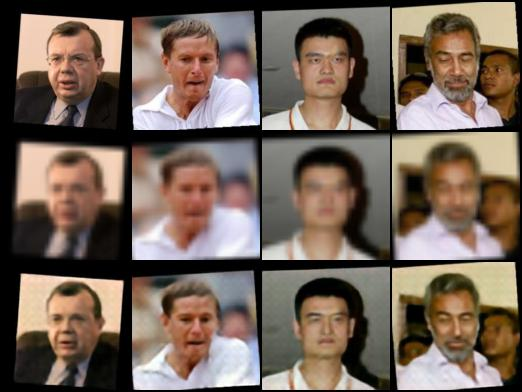

In [0]:
from IPython.display import Image,display_jpeg
display_jpeg(Image('cnn_upscale.jpg'))


In [30]:
!wget http://www.robots.ox.ac.uk/~vgg/data/flowers/102/102flowers.tgz
!tar xf 102flowers.tgz
!mkdir oxford-102
!mkdir oxford-102/jpg
!mv jpg/*.jpg oxford-102/jpg


--2018-12-28 07:23:40--  http://www.robots.ox.ac.uk/~vgg/data/flowers/102/102flowers.tgz
Resolving www.robots.ox.ac.uk (www.robots.ox.ac.uk)... 129.67.94.2
Connecting to www.robots.ox.ac.uk (www.robots.ox.ac.uk)|129.67.94.2|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 344862509 (329M) [application/x-gzip]
Saving to: ‘102flowers.tgz’

102flowers.tgz      100%[===================>] 328.89M  13.6MB/s    in 21s     

2018-12-28 07:24:02 (15.5 MB/s) - ‘102flowers.tgz’ saved [344862509/344862509]



In [0]:
img_data = ImageFolder("/content/oxford-102/",
    transform=transforms.Compose([
        transforms.Resize(80),
        transforms.CenterCrop(64),
        transforms.ToTensor()
]))

batch_size = 64
img_loader = DataLoader(img_data, batch_size=batch_size,
                        shuffle=True)


In [0]:
nz = 100
ngf = 32
class GNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.main = nn.Sequential(
            nn.ConvTranspose2d(nz, ngf * 8, 
                               4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(ngf * 8, ngf * 4,
                               4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(ngf * 4, ngf * 2,
                               4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(ngf * 2, ngf,
                               4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(ngf, 3,
                               4, 2, 1, bias=False),
            nn.Tanh()
        )
        
    def forward(self, x):
        out = self.main(x)
        return out


In [0]:
ndf = 32

class DNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.main = nn.Sequential(
            nn.Conv2d(3, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
        )
    
    def forward(self, x):
        out = self.main(x)
        return out.squeeze()


In [0]:
d = DNet().to("cuda:0")
g = GNet().to("cuda:0")

# Adam의 파라미터는 원 논문에서 제안하는 값
opt_d = optim.Adam(d.parameters(),
    lr=0.0002, betas=(0.5, 0.999))
opt_g = optim.Adam(g.parameters(),
    lr=0.0002, betas=(0.5, 0.999))

# 크로스 엔트로피를 계산하기 위한 보조 변수 등
ones = torch.ones(batch_size).to("cuda:0")
zeros = torch.zeros(batch_size).to("cuda:0")
loss_f = nn.BCEWithLogitsLoss()

# 모니터링용 z
fixed_z = torch.randn(batch_size, nz, 1, 1).to("cuda:0")


In [0]:
from statistics import mean

def train_dcgan(g, d, opt_g, opt_d, loader):
    # 생성 모델, 식별 모델의 목적 함수 추적용 배열
    log_loss_g = []
    log_loss_d = []
    for real_img, _ in tqdm.tqdm(loader):
        batch_len = len(real_img)
        
        # 실제 이미지를 GPU로 복사
        real_img = real_img.to("cuda:0")
        
        # 가짜 이미지를 난수와 생성 모델을 사용해 만든다
        z = torch.randn(batch_len, nz, 1, 1).to("cuda:0")
        fake_img = g(z)
        
        # 나중에 사용하기 위해서 가짜 아미지의 값만 별도로 저장해둠
        fake_img_tensor = fake_img.detach()
        
        # 가짜 이미지에 대한 생성 모델의 평가 함수 계산
        out = d(fake_img)
        loss_g = loss_f(out, ones[: batch_len])
        log_loss_g.append(loss_g.item())

        # 계산 그래프가 생성 모델과 식별 모델 양쪽에
        # 의존하므로 양쪽 모두 경사하강을 끝낸 후에
        # 미분 계산과 파라미터 갱신을 실시
        d.zero_grad(), g.zero_grad()
        loss_g.backward()
        opt_g.step()
        
        #실제 이미지에 대한 식별 모델의 평가 함수 계산
        real_out = d(real_img)
        loss_d_real = loss_f(real_out, ones[: batch_len])
        
        # PyTorch에선 동일 Tensor를 포함한 계산 그래프에
        # 2회 backward를 할 수 없으므로 저장된 Tensor를
        # 사용해서 불필요한 계산은 생략
        fake_img = fake_img_tensor
        
        # 가짜 아미지에 대한 식별 모델의 평가 함수 계산
        fake_out = d(fake_img_tensor)
        loss_d_fake = loss_f(fake_out, zeros[: batch_len])
        
        # 진위 평가 함수의 합계
        loss_d = loss_d_real + loss_d_fake
        log_loss_d.append(loss_d.item())
        
        # 식별 모델의 미분 계산고 파라미터 갱신
        d.zero_grad(), g.zero_grad()
        loss_d.backward()
        opt_d.step()
                                             
    return mean(log_loss_g), mean(log_loss_d)


In [0]:
for epoch in range(300):
    train_dcgan(g, d, opt_g, opt_d, img_loader)
    # 10회 반복마다 학습 결과를 저장
    if epoch % 10 == 0:
        # 파라미터 저장
        torch.save(
            g.state_dict(),
            "/content/g_{:03d}.prm".format(epoch),
            pickle_protocol=4)
        torch.save(
            d.state_dict(),
            "/content/d_{:03d}.prm".format(epoch),
            pickle_protocol=4)
        # 모니터링용 z로부터 생성한 이미지 저장
        generated_img = g(fixed_z)
        save_image(generated_img,
                   "/content/{:03d}.jpg".format(epoch))



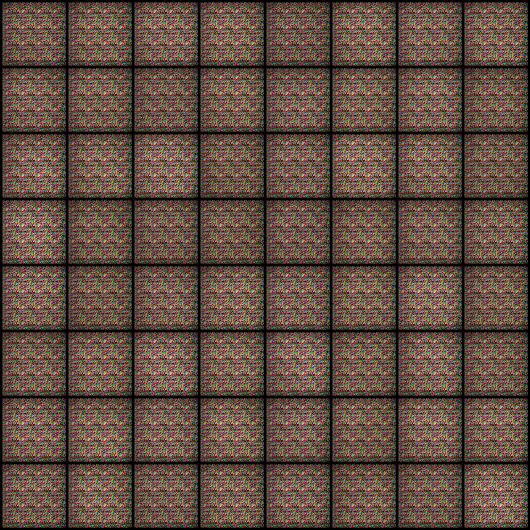

In [40]:
from IPython.display import Image,display_jpeg
display_jpeg(Image('/content/000.jpg'))
